<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install transformers --upgrade
#!pip install transformers -q
#!pip install wandb -q
!pip3 install --upgrade wandb
!pip3 install dill -q

In [3]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
import dill
import tarfile
import json, gzip
import math
from typing import Optional, Union
import os

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH
#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .


from optimizers import AdaFactor

In [5]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Thu Jul 23 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [ ]:
##!wandb login fac9119080ca108ca15c420ede645a5e6e79a07c

### First Log in 

In [6]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Final_Project.ipynb'

#### Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading data**

In [ ]:
# fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

# tar = tarfile.open(fname, "r:")
# tar.extractall()
# tar.close()

In [ ]:
#!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'

In [ ]:
#!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [4]:
#path = '/home/jupyter/' # GCp
path = '/root/release/' # SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
#testset = read_data(path, 'test')

In [5]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
# test_data = get_data(testset)

In [9]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [10]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [6]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [12]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64, text       0
 summary    0
 dtype: int64)

##### Preprocessing

In [7]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    #X = X[self.column].replace(self.contraction)
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [8]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)

    max_len, final_data = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, max_len

In [9]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [10]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


995041it [00:31, 31844.18it/s]


Done!


In [12]:
train_processed.to_pickle("./train_processed.pkl")

In [7]:
train_processed = pd.read_pickle("./train_processed.pkl")

In [13]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


108837it [00:03, 32442.50it/s]


Done!


In [14]:
valid_processed.to_pickle("./valid_processed.pkl")

In [8]:
valid_processed = pd.read_pickle("./valid_processed.pkl")

In [9]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951381 entries, 0 to 951380
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         951381 non-null  object
 1   summary      951381 non-null  object
 2   article_len  951381 non-null  int64 
 3   summary_len  951381 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.0+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

In [28]:
doc_lengths

In [9]:
indices = np.where(train_processed['summary_len'] < 10)
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)
#train_processed.iloc[indices[0]]

In [30]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [32]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882676 entries, 0 to 882675
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         882676 non-null  object
 1   summary      882676 non-null  object
 2   article_len  882676 non-null  int64 
 3   summary_len  882676 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 26.9+ MB


In [33]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [34]:
train_processed_data['article_len'].quantile([0.1,0.25,0.4,0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.1000      192.000
0.2500      322.000
0.4000      465.000
0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [35]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104147 entries, 0 to 104146
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         104147 non-null  object
 1   summary      104147 non-null  object
 2   article_len  104147 non-null  int64 
 3   summary_len  104147 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [37]:
valid_doc_lengths

In [10]:
inds = np.where(valid_processed['summary_len'] < 10)
#valid_processed.iloc[inds[0]]
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [5]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [6]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [7]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [11]:
art = 512 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 150# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:512, sum len:150


In [12]:
artV = 512 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 150# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:512, sum len:150


#### Creating Custom Dataset

In [13]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


In [14]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Training Loop

In [15]:
def training(model, dataset_loader, optimizer, log_interval, regularizer, iteration=0):

    model.train()
    avg_loss = 0
    nItem = 0


    print(f'Start training for epoch: {iteration}')
    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))
 
    for idx, data_train in enumerate(tqdok):

        input_ids, source_mask, summary_ids, summary_mask = data_train

        input_ids = input_ids.to(device, dtype = torch.long)
        source_mask = source_mask.to(device, dtype = torch.float)
        summary_ids = summary_ids.to(device, dtype = torch.long)

        target_labels = summary_ids[:, :-1].contiguous()
        langm_labels = summary_ids[:, 1:].clone().detach()
        langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

        loss = output[0]

        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        nItem += bs        
        
#         itr = iteration*(len(dataset_loader.dataset)//bs) + idx
#         optimizer.param_groups[0]['eps'] = eps_sched[itr]

        avg_loss += loss.item() * bs

        if idx%log_interval == 0:
                wandb.log({"Training Loss": loss.item()})
#         if idx % 5000 == 0:
#           print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
        
        losses.update(loss.item(), bs)
        tqdok.set_postfix(loss=losses.avg)
        
    avg_loss /= nItem
  
    return avg_loss, output


In [16]:
def validation(model, dataset_loader, regularizer):
    model.eval()

    eval_loss = 0
    nItem = 0

    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))

    with torch.no_grad():
        for idx, data_val in enumerate(tqdok):
            input_ids, source_mask, summary_ids, summary_mask = data_val

            input_ids = input_ids.to(device, dtype = torch.long)
            source_mask = source_mask.to(device, dtype = torch.float)
            summary_ids = summary_ids.to(device, dtype = torch.long)

            target_labels = summary_ids[:, :-1].contiguous()
            langm_labels = summary_ids[:, 1:].clone().detach()
            langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

            output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, lm_labels=langm_labels, lamda=regularizer)

            loss = output[0]

            bs = input_ids.size(0)
            nItem += bs

            eval_loss += loss.item()

            losses.update(loss.item(), bs)
            tqdok.set_postfix(loss=losses.avg)

    eval_loss /= nItem

    return eval_loss

In [19]:
def saving(PATH, epoch, avg_loss, model,pp, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': avg_loss,
            'perplexity': pp,
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.


#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [17]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [18]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 2.108e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
t5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
class GatedFilterLayer(nn.Module):
  r"""
  Receives the keys from the encoder output.

  Returns:
    Output the values between [0,1]
   """

  def __init__(self, hidden_size_model):
    super(GatedFilterLayer, self).__init__()

    self.hidden_size_model = hidden_size_model
    self.projector = nn.Linear(hidden_size_model, 1)

    self.init_weights()

  def init_weights(self):
    initrange = 0.1
    self.projector.bias.data.zero_()
    self.projector.weight.data.uniform_(-initrange, initrange)

  def forward(self, last_hidden_encoder):
    proj = self.projector(last_hidden_encoder)
    gate = torch.sigmoid(proj)
    hidden_encoder = gate * last_hidden_encoder
    return hidden_encoder, gate

In [20]:
class EncoderModule(nn.Module):

  def __init__(self, T5ForGmodel=None, model_name = 't5-base'):
    super(EncoderModule, self).__init__()

    if T5ForGmodel is None:

      MODEL_NAME = model_name 
      if MODEL_NAME not in ['t5-base','t5-small','t5-large','t5-3b','t5-11b']:
        raise NameError('Name {} is not specified in T5 model names'.format(MODEL_NAME))

      T5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
      self.encoder_model = T5model.encoder
      dmodel = T5model.config.d_model
    else:
      self.encoder_model = T5ForGmodel.encoder
      dmodel = T5ForGmodel.config.d_model

    self.gatefilter = GatedFilterLayer(dmodel)


  def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, head_mask=None, output_hidden_states=False):
    
    if input_ids is None and inputs_embeds is None:
      raise ValueError("You have to specify either input_ids or input_embeds")
    
    if self.encoder_model.config.output_hidden_states or output_hidden_states:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask,
                                      output_hidden_states=True)
    else:
      encoder_out =  self.encoder_model(input_ids=input_ids, 
                                      attention_mask=attention_mask,
                                      inputs_embeds=inputs_embeds,
                                      head_mask=head_mask)
    lst_enc_hidden = encoder_out[0]
    last_hidden_out, gate = self.gatefilter(lst_enc_hidden)

    last_hidden_out = (last_hidden_out, ) + encoder_out[1:] + (gate,)

    return last_hidden_out

In [21]:
class GatedT5ForSummurization(nn.Module):
  
  """
  Gated T5 with Language Model
  
  """

  def __init__(self,t5model=None, MODEL_NAME='t5-base'):
    super(GatedT5ForSummurization, self).__init__()

    self.encoder = EncoderModule(T5ForGmodel=t5model, model_name=MODEL_NAME)
    
    if t5model is None:
        self.decoder = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
    else:
        self.decoder = t5model

  def forward(self,input_ids=None, attention_mask=None,
              decoder_input_ids=None,decoder_attention_mask=None,
              decoder_past_key_value_states=None,use_cache=True,lm_labels=None,
              inputs_embeds=None,decoder_inputs_embeds=None, head_mask=None,
              output_hidden_states=False,lamda = 0.0,
             ):

    encoder_outputs = self.encoder(input_ids=input_ids, 
                                   attention_mask=attention_mask,
                                   inputs_embeds=inputs_embeds, 
                                   head_mask=head_mask,
                                   output_hidden_states=output_hidden_states)

    decoder_outputs = self.decoder(
            encoder_outputs=encoder_outputs,
            decoder_input_ids = decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            decoder_past_key_value_states = decoder_past_key_value_states,
            use_cache=use_cache,
            lm_labels = lm_labels,
            decoder_inputs_embeds=decoder_inputs_embeds,
            head_mask=head_mask)
        
    # Computing MLE Loss + L1 Norm Reg on LN weight
    if lm_labels is not None:

      Loss_MLE = decoder_outputs[0]
      #weight = self.encoder.gatefilter.projector.weight
      gate = encoder_outputs[-1]
      Loss_gate = torch.sum(gate.squeeze(-1))/(gate.shape[0]*gate.shape[1]) * lamda
      Loss = Loss_MLE + Loss_gate
    
      decoder_outputs = (Loss,) + decoder_outputs[1:]
      
    return decoder_outputs

  def generate(self,
               input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None):

    """
    All possible inputs receive by the generator
    For more details look @ huggingface documentation
    
        input_ids = None, max_length = None, min_length = None,do_sample = None,
        early_stopping = None,num_beams = None,temperature= None,top_k: Optional[int] = None,
        top_p: Optional[float] = None, repetition_penalty = None,bad_words_ids = None,
        bos_token_id  = None, pad_token_id  = None,eos_token_id = None,length_penalty= None,
        no_repeat_ngram_size = None,num_return_sequences = None,attention_mask = None,
        decoder_start_token_id = None,use_cache: Optional[bool] = None
    """

    return self.decoder.generate(input_ids = input_ids, max_length = max_length, min_length = min_length,do_sample = do_sample,
        early_stopping = early_stopping,num_beams = num_beams,temperature= temperature,top_k = top_k,
        top_p = top_p, repetition_penalty = repetition_penalty,bad_words_ids = bad_words_ids,
        bos_token_id  = bos_token_id, pad_token_id  = pad_token_id,eos_token_id = eos_token_id,length_penalty= length_penalty,
        no_repeat_ngram_size = no_repeat_ngram_size,num_return_sequences = num_return_sequences,attention_mask = attention_mask,
        decoder_start_token_id = decoder_start_token_id,use_cache = use_cache
    )

In [22]:
model = GatedT5ForSummurization(t5model=t5model)


In [47]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [23]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [24]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [25]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

In [44]:
Xtrain_trial = X_train.iloc[:50000]
Xvalid_trial = X_valid.iloc[:3600]

In [26]:
indices = np.random.permutation(len(X_train))
valind = np.random.permutation(len(X_valid))

ind = indices[:70000]
vind = valind[:5000]

Xtrain_trial = X_train.iloc[ind]
Xvalid_trial = X_valid.iloc[vind]

Xtrain_trial = Xtrain_trial.reset_index(drop=True)
Xvalid_trial = Xvalid_trial.reset_index(drop=True)

In [25]:
N_EPOCHS = 2
path = '/content/drive/My Drive/Colab Notebooks/best_model.pth'
pcle = '/content/drive/My Drive/Colab Notebooks/optimizer_state_dict.pkl'
#filename = open(pcle, 'wb')

In [27]:
def run(model,
        X_train, X_valid, 
        path=None,filename=None,
        lr= LEARNING_RATE):

    #best_loss = float('inf')
    #best_pp = float('inf')
    # WandB – Initialize a new run
    
    wandb.init(entity="jp-ishimwe", project="test-summaries")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-test")
    #wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
#     wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          
    config.BATCH_SIZE = 6
    config.EVAL_BATCH_SIZE = 8
    config.N_EPOCHS = 3 
    config.LEARNING_RATE = lr
    config.SEED = 42               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 500     # how many batches to wait before logging training status
    config.reg = 0.1081

    random.seed(config.SEED)
    np.random.seed(config.SEED)
    torch.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    
    kwargs = {'max_article_tokens': config.art_maxlen,
                'max_summary_tokens': config.summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': config.Valid_art_maxlen,
                'max_summary_tokens': config.Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, config.BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, config.EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    optimizer = AdaFactor(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    wandb.watch(model, log="all")
    wandb.unwatch(model) 

#     maxiter = config.N_EPOCHS*(len(train_loader.dataset)//config.BATCH_SIZE)
#     eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))

    for epoch in range(config.N_EPOCHS):

        avg_loss, outputs = training(model, train_loader, optimizer, config.log_interval, regularizer=config.reg, iteration=epoch)
        print('\nValidation start:')
        eval_loss = validation(model, val_loader, regularizer=config.reg)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.4f}')
        print(f'Perplexity: {pp:.4f} | Eval loss: {eval_loss:.4f}')
        print("--------------")


        wandb.log({
            "Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})


        # Save model to wandb
#         torch.save(model.state_dict(), os.path.join(wandb.run.dir, 'model0.pt'))
        torch.save(model.state_dict(), '/root/Projectsmodel0.pt')


    return train_loss, perplexity, val_loss, outputs


    #     if pp < best_pp:
    #       best_pp = pp
    #       saving(path, epoch, avg_loss, model, pp, lr)
    #       dill.dump(optimizer, filename)

    # Save model for every 3 epochs
    # if i%3==0:
    #   torch.save(model.state_dict(), path)
    #print(f'Best Perplexity: {best_pp}')
    #filename.close()

In [28]:
train_loss, perplexity, eval_loss, outputs = run(model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE)

  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 0


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:35<00:00,  4.01it/s, loss=1.52]


Epoch loss: 1.71
Perplexity: 1.209 | Eval loss: 0.19
--------------


  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 1


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:35<00:00,  4.01it/s, loss=1.49]


Epoch loss: 1.50
Perplexity: 1.205 | Eval loss: 0.19
--------------


  0%|          | 0/11667 [00:00<?, ?it/s]

Start training for epoch: 2


  0%|          | 0/625 [00:00<?, ?it/s]


Validation start:


100%|██████████| 625/625 [02:35<00:00,  4.01it/s, loss=1.48]


Epoch loss: 1.37
Perplexity: 1.204 | Eval loss: 0.19
--------------


In [34]:
gates = outputs[-1].squeeze(-1) 

In [35]:
gates.mean(dim=1,keepdim=True)

tensor([[0.1661],
        [0.2258],
        [0.3560],
        [0.3269]], device='cuda:0', grad_fn=<MeanBackward1>)

In [36]:
values, _ = gates.max(dim=1,keepdim=True)
values

tensor([[0.5192],
        [0.5296],
        [0.5251],
        [0.5483]], device='cuda:0', grad_fn=<MaxBackward0>)

In [37]:
vals, _ = gates.min(dim=1,keepdim=True)
vals

tensor([[0.0292],
        [0.0303],
        [0.1157],
        [0.0288]], device='cuda:0', grad_fn=<MinBackward0>)

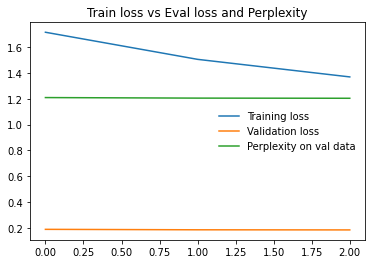

In [29]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [20]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.decoder.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
pretrained = False

if pretrained:    

    model = .... # first initialize the model and optimizer

    #optimizer = ... # optimizer then,
    infile = open(pcle,'rb')
    optimizer = pickle.load(infile)
    infile.close()

    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

In [61]:
!ls /root/Projects


Final_Project.ipynb	     Wheat_rust_classification.ipynb
README.md		     model.pt
T5_ftransfer_learning.ipynb  valid_processed.pkl
Untitled.ipynb		     wandb


In [22]:
model.load_state_dict(torch.load('/root/Projectsmodel0.pt'))
model = model.to(device)

In [23]:
#model = torch.load('/root/Projects/model.pt')

In [27]:
ivind = valind[5000:6000]

X_trial = X_valid.iloc[ivind]

Xtest_trial = X_trial.reset_index(drop=True)

argsval = {'max_article_tokens': 512,
                'max_summary_tokens': 150
             }
    
    
val_loader  = get_dataloader(Xtest_trial, 5,valid='valid', **argsval)

In [28]:
%time results = generator(model, val_loader)

CPU times: user 6min, sys: 12 s, total: 6min 12s
Wall time: 6min 1s


#### Visualizing examples

**Example 1**

In [31]:
Xtest_trial.iloc[0,:]['text']

'Image Mashable composite Justin Sullivan Getty Images, Sasha Mordovets Getty Images\n\nDonald Trump finally found a running mate just as, shall we say, respected, as himself Vladimir Putin.\n\nJust kidding! The duo aren t actually political partners despite having nothing but complimentary words for each other earlier this week but that didn t stop GOP presidential candidate John Kasich from creating a satirical campaign website and press release announcing Putin as Trump s choice for VP.\n\nWho cares about the Constitution when you have something as amazing as TRUMP PUTIN 2016?! \n\n Trump Putin 2016 December 19, 2015\n\nKasich campaign also out with a press release TRUMP NAMES PUTIN AS HIS RUNNING MATE pic.twitter.com R83oMtdg69\n\n Zeke Miller December 19, 2015\n\nThe biting website boasts the slogan Make tyranny great again parodying Trump s Make America great again phrase.\n\nIt also mocks Trump s and Putin s bombastic and controversial views with disclaimers like By signing up y

In [29]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'GOP presidential candidate John Kasich created a satirical website and press release announcing Vladimir Putin as Trump s VP choice.'

In [30]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'Donald Trump finally found a running partner just as, shall we say respect. Just kidding! The duo arent actually political partners but that didn GOP presidential candidate John Kasich from creating satirical campaign website and press release announcing Putin as his choice for VP'

**Example 2**

In [32]:
Xtest_trial.iloc[1,:]['text']

'PORT AU PRINCE, Haiti Oh, what a party there would have been. Sound trucks with towering speakers. Dancers in eye catching outfits. Three days of rum fueled, dusk to dawn debauchery.\n\nLynsey Addario for The New York Times\n\nHaitians danced and sang religious songs Sunday in Port au Prince. The quake hit just as Carnival season was gearing up.\n\nBut Haiti s Carnival was called off, replaced with an equal period of mourning, and the grand Champ de Mars square on Sunday had none of the boisterous joy that usually breaks out this time of year. Religious leaders shouted out sermons and their followers, packed together tightly, held their arms toward the sky. Some Haitians did take to the streets for some dancing on Sunday. But most of all there was glumness across this crumbled capital.\n\n It would have been such a big day, said Ralph Severe, 28, who had been set to dance in the 2010 Carnival parade here. There would have been so much music, so many colors. \n\nA reviewing stand, wher

In [33]:
print("Actual summary:")
results['golden_summary'][1]

Actual summary:


'Haiti s three day Carnival was called off, replaced with an equal period of mourning in Port au Prince.'

In [34]:
print('Generated summary:')
results['generated_summary'][1]

Generated summary:


'PORT A Prince, Haiti Oh what an annual national celebration after such a devastating natural disaster, there was no debate about whether it ought to go on so soon.'

**Example 3**

In [35]:
Xtest_trial.iloc[3,:]['text']

'WASHINGTON As he struggles to sell his nuclear deal with Iran to resistant Republicans and Democrats in Congress, President Obama describes it in the narrowest possible terms, as a limited transaction in which Tehran gives up the bomb and gets sanction relief in return.\n\nIn a conference call with liberal groups on Thursday night, he stuck to his talking points The principal danger is if the Iranians get a nuclear weapon, which is exactly what this deal prevents. \n\nWhat the president and his aides do not talk about these days for fear of further antagonizing lawmakers on Capitol Hill who have cast Iran as the ultimate enemy of the United States are their grander ambitions for a deal they hope could open up relations with Tehran and be part of a transformation in the Middle East.\n\n Over 15 years, things happen in countries, and if you look at Iran today, very educated, used to be very friendly with a lot of nations in the region, including Israel, Secretary of State John Kerry sai

In [36]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'The Obama administration may have grander ambitions to open up American relations with Tehran and be part of a transformation in the Middle East.'

In [37]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'President Obama describes his nuclear deal with Iran in the narrowest possible terms, as a limited transaction in which Tehran gives up its support for President Bashar al'

**Example 4**

In [38]:
Xtest_trial.iloc[4,:]['text']

'Image by AFP Getty Images via \n\nMundra Port and Special Economic Zone, India s largest private sector port operator owned by Gautam Adani, the country s sixth richest person net worth 10 billion , won a 2 billion bid to acquire Abbot Point Port in Queensland, Australia on a 99 year lease. Owned by the North Queensland Bulk Ports Corporation, Abbot Point has a deepwater coal terminal capable of handling 50 million tons annually.\n\nIn a statement released to the Bombay Stock Exchange where Mundra is listed, Adani said that the deal for Abbot was in keeping with his international aspirations for Mundra. We were in search of the right business opportunity with a strategic fit. \n\nThis latest purchase, Adani s second in Australia, ties in with his acquisition last year of a valuable coal mining lease from Linc Energy for 2.7 billion including royalties , also located in the northern part of Queensland.\n\nAdani, who has substantial interests in power, has been among those leading the r

In [39]:
print("Actual summary:")
results['golden_summary'][4]

Actual summary:


'Gautam Adani s Adani Group wins bid for Abbot Point'

In [40]:
print('Generated summary:')
results['generated_summary'][4]

Generated summary:


'India s largest private sector port operator won 2 billion bid to acquire Abbot Point Port in Queensland, Australia on 99 year lease. Mundra, located on India and Gujarat, has capacity of 50 million tons and ambition is to become country 10'

**Example 5**

In [41]:
Xtest_trial.iloc[5,:]['text']

'Twelve year old twins who were unconscious when firefighters carried them out of a burning townhouse unit in Gatineau, Que., died in hospital Sunday evening, the mother of the boy and girl told Radio Canada.\n\nGabrielle and Jacob Rondeau, both 12, were asleep in their Gatineau, Que., townhome unit when a fire broke out late Saturday night. They died Sunday night in hospital.\n\nGabrielle and Jacob Rondeau, both 12, were asleep in their Gatineau, Que., townhome unit when a fire broke out late Saturday night. They died Sunday night in hospital.\n\nGabrielle and Jacob Rondeau were asleep on Saturday night when their 17 year old brother left them alone in the townhome on Marengere Road to go get pizza with his girlfriend, he told Radio Canada.\n\nDaniel Rondeau said firefighters were battling smoke and flames when he returned around 11 p.m. ET.\n\nThe twins were unconscious when they were rescued from their second floor unit.\n\nNeighbour Andre Valliquette said the twins had been at his 

In [42]:
print("Actual summary:")
results['golden_summary'][5]

Actual summary:


'Twelve year old twins who were unconscious when firefighters carried them out of a burning townhome in Gatineau, Que., died in hospital Sunday evening, the mother of the boy and girl told Radio Canada.'

In [43]:
print('Generated summary:')
results['generated_summary'][5]

Generated summary:


'Twelve year old twins who were unconscious when firefighters carried them out of a burning townhouse unit in Gatineau, Que. died Sunday evening, the mother and father told Radio Canada'

**Example 6**

In [44]:
Xtest_trial.iloc[6,:]['text']

'It is Syria s misfortune that its torment at the hands of Bashar al Assad and his murderous cronies had to come after the West s ordeals in Iraq and Afghanistan, and in the wake of a global financial crisis that has left accountants in charge of foreign policy. Wearied and broke, we have no appetite for another military adventure.\n\nOur impotence in the face of daily horrors from Damascus, Homs, Deraa, Aleppo and countless other places martyred in the savagery of this civil war is obvious to the world. The interventionist idealism Tony Blair mapped out in Chicago more than a decade ago never recovered from its humiliations in Basra and Helmand. Now we are reduced to wringing our hands on the sidelines, incapable even of addressing the war s humanitarian consequences. Images claiming to depict the victims of a chemical attack on civilians by the regime s forces have provoked lamentations of despair and little else. Barack Obama said last year that the use of such weapons was the red l

In [45]:
print("Actual summary:")
results['golden_summary'][6]

Actual summary:


'From Tuesday s Daily Telegraph It is Syria s misfortune that its torment at the hands of Bashar al Assad and his murderous cronies had to come after the West s ordeals in Iraq and Afghanistan, and in the wake of a global financial crisis that has left accountants in charge of foreign policy. Wearied and broke, we have'

In [46]:
print('Generated summary:')
results['generated_summary'][6]

Generated summary:


'It is Syria s misfortune that its torment at the hands of Bashar al Afi and his murderous cronies hadto come after Iraq, Afghanistan and inthe wake.'

**Example 7**

In [47]:
Xtest_trial.iloc[7,:]['text']

'WILMINGTON, Del. A 16 year old Delaware girl is dead, leaving her family and town devastated.She died after a fight in a high school bathroom, but it s unclear how or why.\n\nIn a cellphone video, Amy Joyner is seen on her knees before she was allegedly killed by a group of girls in a bathroom brawl.\n\nWilmington police confirm the horrific attack was filmed perhaps by more than one girl. Police say no weapons were used. Joyner was airlifted Thursday to a local hospital, where she died shortly after arriving.\n\nAn image taken from a cellphone video shows Amy Joyner, right, being punched during a fight shortly before she died.\n\nAuthorities say they have questioned three girls who have now been suspended from school.\n\n Now they know they re in very serious trouble and could spend a substantial amount of time in prison, Mayor Dennis Williams told CBS News.\n\nWhen asked if he thinks that s what should happen to the teenagers, Williams responded, I m a retired police officer. If the

In [48]:
print("Actual summary:")
results['golden_summary'][7]

Actual summary:


'Three girls have been questioned by Delaware police, suspended from school in connection with 16 year old Amy Joyner s death'

In [49]:
print('Generated summary:')
results['generated_summary'][7]

Generated summary:


'A 16 year old Delaware girl is dead, leaving her family and town devastated.She died after a fight in the high school bathroom, but it'

**Example 8**

In [50]:
Xtest_trial.iloc[8,:]['text']

'When Tyler Atkins heard about the fatal shooting of Michael Brown, 18, an unarmed black teenager in Ferguson, Mo., he posted on Twitter a picture of himself in a tuxedo, with a saxophone around his neck, next to a photograph of himself dressed in a black T shirt with a blue bandanna tied around his head and his finger pointed at the camera.\n\nLike hundreds of young African Americans, he placed his pictures under the hashtag protesting Mr. Brown s killing by a police officer and the way young black men are depicted in the news media. He said that Mr. Brown s identity was distorted and filtered through negative stereotypes, and that the same would have been done to him with the bandanna image if he found himself the victim of a similar event.\n\nThe first picture was taken after a jazz concert at the High School for the Performing and Visual Arts in Houston, where Mr. Atkins, a senior, studies music. The other was taken during a recording for a rap video he made with friends for a scho

In [51]:
print("Actual summary:")
results['golden_summary'][8]

Actual summary:


'The police shooting of Michael Brown, a Missouri teenager, has prompted a social media campaign over negative depictions of young black men in the news media.'

In [52]:
print('Generated summary:')
results['generated_summary'][8]

Generated summary:


'When Tyler Atkins heard about the fatal shooting of Michael Brown, 18, an unarmed black teenager in Ferguson. he posted on Twitter a picture of himself wearing tuxedo next to rap video he made with friends for school math project.'

**Example 9**

In [53]:
Xtest_trial.iloc[9,:]['text']

'NEW YORK A walk along the East River in Brooklyn is like no other stroll along the waterfront. Sure, there are the obligatory benches and paved paths that open up to breathtaking vistas of the Manhattan skyline.\n\nBut for 1.3 miles along the river s edge, visitors experience playgrounds, soccer fields, basketball courts, an outdoor roller rink, a pop up swimming pool, cafes, barbecue pits, beaches, and performance spaces. And just when you think it can t get any better, you spy a hand painted carousel that spins under the Brooklyn Bridge.\n\nNow this is how you develop a waterfront.\n\nBrooklyn Bridge Park is a six year old public space that Jim Canales, president of the Barr Foundation in Boston, has hailed as a model. Turns out a bunch of Bostonians who are shaping our own harbor s edge have also checked out the 85 acre park.\n\nAfter visiting the space last week, I couldn t help but think about our own Seaport District, with its ho hum towers, and ask Did we just blow it?\n\nNew Y

In [54]:
print("Actual summary:")
results['golden_summary'][9]

Actual summary:


'It s not too late for us to improve our waterfront. Brooklyn Bridge Park is a model for success.'

In [55]:
print('Generated summary:')
results['generated_summary'][9]

Generated summary:


'A walk along the East River in Brooklyn is like no other stroll along a waterfront. But for 1.3 miles along its edge, visitors experience playgrounds, soccer fields and basketball courts'

**Example 10**

In [56]:
Xtest_trial.iloc[15,:]['text']

'The Carolina Panthers are 13 0 and closing in on the fifth perfect regular season in N.F.L. history, with quarterback Cam Newton making a strong case for the Most Valuable Player Award.\n\nThe Giants are 6 7, have a habit of throwing games away late and are alive in the playoff chase only because they are lucky enough to play in the pitiful N.F.C. East.\n\nSo Sunday s game between the teams might seem like a mismatch. What would one expect the opening betting line on the game to be? Ten points? Fourteen? More?\n\nThe head scratchingly low number may have caused some fans to grab their wallets and rush to the nearest legal or illegal bookmaker. But before you take out a second mortgage, it is worth considering why the line is as low as it is.\n\n The Giants are hosting the game, which is generally considered to be worth about 3 points. By extension, a neutral site game between the teams might have a line of 7 and a game in Carolina a line of 10, both of which feel more right.\n\n The P

In [57]:
print("Actual summary:")
results['golden_summary'][15]

Actual summary:


'Bookmakers remained skeptical about the Panthers 13 0 record, making them only 4 point favorites in the opening betting line for their game against the 6 7 Giants.'

In [58]:
print('Generated summary:')
results['generated_summary'][15]

Generated summary:


'The Carolina Panthers are less impressive than one might expect a perfect team to be, with fewer lines. But answering it can devilishly complicated'

### Performance

In [59]:
!pip3 install rouge
from rouge import Rouge

In [60]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

In [61]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [62]:
get_score(results)

{'rouge1': 0.3251555298232545,
 'rouge2': 0.17724507880716306,
 'rougeL': 0.2734545655096767}

In [63]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.2934569607894014,
 'rouge-2': 0.16207342615668757,
 'rouge-l': 0.2762959592687011}

##### Freezing layers

In [ ]:
model.decoder.block[11].requires_grad=True
model.decoder.block[4].requires_grad=True

for param model.parameters():
    param.requires_grad = False

In [ ]:
class T5Model(nn.Module):

  def __init__(self, t5, )

In [ ]:
class DictionaryDataset:
  def __init__(self, dataset=None):
    self.w2index = defaultdict(int)
    self.index2w = defaultdict(lambda: 'SOS')
    self.symbols = ['SOS','EOS','PAD']
    self.wcount = 3

    for i, s in enumerate(self.symbols):
      self.index2w[i] = s
    for i, s in enumerate(self.symbols):
      self.w2index[s] = i
      
    if dataset:
      for i, line in tqdm(enumerate(dataset)):
        self.word2index(line)

  def word2index(self, sentence):
    words = sentence.split()
    for word in words:
      if word not in self.w2index.keys():
        self.w2index[word] = self.wcount
        self.index2w[self.wcount] = word
        self.wcount +=1
    
  def encode_sequence(self, dataset):
    for i, line in tqdm(enumerate(dataset)):
      self.word2index(line)

  def decode_idx(self, idx):
    dec_words = []
    for i in idx:
      dec_words.append(self.index2w[i])
    return dec_words

![LSTM](https://drive.google.com/open?id=19pYBGaKGx2wTHjDC3QLMkpr5HDqTPbb6)

![Seq2SeqWithAttention](https://drive.google.com/open?id=1QDLNN0XQ0TfeA-nyAGBhG3YgwAX0bPQU)

You should use the same number of layers, for encoder and decoder
shape for inputs is (batch size, sequence length), (batch size, 1) respectively.


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size, embed_size, num_hidden, batch_size, num_layers=3, dropout = 0.1):
    super(Encoder, self).__init__()
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.input_size = input_size
    self.batch_size = batch_size

    self.embed = nn.Embedding(input_size, embed_size)
    self.lstm = nn.LSTM(input_size=embed_size, hidden_size=num_hidden,num_layers = num_layers, dropout=(0 if num_layers ==2 else dropout))

  def init_hidden(self):
     # The axes semantics are (num_layers, minibatch_size, hidden_dim)
    return (torch.zeros(self.num_layers, self.batch_size, self.num_hidden), torch.zeros(self.num_layers, self.batch_size, self.num_hidden))
  def forward(self, input, hidden):
    # input (batch size, sequence length)
    embedding = self.embed(input)
    #print(embedding.shape)
    embed_out = embedding.transpose(0,1)
    print(embed_out.shape)
    lstm_out, hidden = self.lstm(embed_out, hidden)

    # The shape of lstm_out is (seq_len, batch_size, num_hiddens).
    # state contains the hidden state and the memory cell
    # of the last time step, the shape is (num_layers, batch_size, num_hiddens)
    #lstout is (seq_length, batch_size, num_hiddens)
    return lstm_out, hidden

In [ ]:
encoder = Encoder(input_size =10, embed_size=8, num_hidden=16, batch_size=4)
X = torch.zeros((4, 7),dtype=torch.long)
hidden = encoder.init_hidden()
output, hidden = encoder(X, hidden)

torch.Size([7, 4, 8])


In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])

In [ ]:
output.shape

torch.Size([7, 4, 16])

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size, method='dot'):
    super(Attention, self).__init__()
    self.method = method
    self.hidden_size = hidden_size
  def dot_score(self, hidden, encoder_output):
    return torch.sum(hidden * encoder_output, dim=2)

  def forward(self, hidden, encoder_output):
    att_prod = self.dot_score(hidden, encoder_output)
    attn_weights = att_prod.t()
    return F.softmax(attn_weights, dim=1).unsqueeze(1)



In [ ]:
class DecoderWithAtt(nn.Module):
  def __init__(self, embed_size_in, num_hidden, output_size, att_method=None, num_layers = 3):
    super(DecoderWithAtt, self).__init__()
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.output_size = output_size
    self.att_method = att_method

    self.emb = nn.Embedding(embed_size_in, num_hidden)
    self.lstm = nn.LSTM(input_size=num_hidden, hidden_size=num_hidden, num_layers = num_layers)
    self.con_ln = nn.Linear(num_hidden * 2, num_hidden)
    self.drop = nn.Dropout(p=0.2)
    self.fc  = nn.Linear(self.num_hidden, self.output_size)
    self.attention = Attention(att_method, num_hidden)

  def forward(self, prev_hidden, target_input, enconder_outputs):
    embed_out = self.emb(target_input).transpose(0,1)
    embed_out = self.drop(embed_out)
    print('embed out >>>', embed_out.shape)
    output, hidden = self.lstm(embed_out, prev_hidden) # shape (1, batch_size, hidden_size), 1 for one time step word 
    print('lstm out >>>', output.shape)
    print('hidden out >>>', hidden[0].shape)

    attent_weights = self.attention(output, enconder_outputs) # (att out shape: batch_size, 1, max_length), enc in shape: (max_length, batch_size, hidden_size)
    print('attent_weights out >>>', attent_weights.shape)
    print('enconder_outputs >>>', enconder_outputs.shape)

    context = torch.bmm(attent_weights, enconder_outputs.transpose(0,1))
    print('context out >>>', context.shape)
    cont_dec_out = torch.cat((context, output.transpose(0,1)), 1)
    print('to linear out >>>', cont_dec_out.shape)
    cont_dec_out = cont_dec_out.view(cont_dec_out.shape[0], -1)
    concat_out = self.con_ln(cont_dec_out)
    concat_out = torch.tanh(concat_out)

    out = self.fc(concat_out)
    out = F.softmax(out, dim=1)

    return out, hidden

In [ ]:
decoder = DecoderWithAtt(10,16,2)

In [ ]:
x = torch.zeros((4, 1),dtype=torch.long)
out, hidden = decoder(hidden, x, output)

embed out >>> torch.Size([1, 4, 16])
lstm out >>> torch.Size([1, 4, 16])
hidden out >>> torch.Size([3, 4, 16])
attent_weights out >>> torch.Size([4, 1, 7])
enconder_outputs >>> torch.Size([7, 4, 16])
context out >>> torch.Size([4, 1, 16])
to linear out >>> torch.Size([4, 2, 16])


In [ ]:
out.shape

torch.Size([4, 2])

In [ ]:
hidden[0].shape

torch.Size([3, 4, 16])